In [26]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [27]:
import ee

In [28]:
ee.Authenticate() 

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=NldOgG-M5NSsiwlaEOr-RUu3ELLbA-Z16CZFBK-d9Vw&tc=per8A4fCqv3jnMSeR9EImById0K-XR5VZYzreBq9eJ8&cc=Y0awKuc_KxPeWaxPXymgd8UiG138FvrD12YQCWLiMpE

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh44COjfzXMYyeLrIZkrSPo6Iq5Bgv8JjBA3vnjdTjrwz96ivt00qr4

Successfully saved authorization token.


In [29]:
import collections #Resolvendo incompatibilidade 
collections.Callable = collections.abc.Callable

In [30]:
ee.Initialize()

In [31]:
pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import geemap
Map = geemap.Map()

In [33]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import geopandas as gpd

In [35]:
ROI_shp = '/content/drive/MyDrive/Scripts/NDVI_script/Bacia_TCC.shp'
ROI = geemap.shp_to_ee(ROI_shp)

In [36]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR") #https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

In [37]:
# Função apara remover nuvens
def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
  return image.updateMask(mask) \
      .select("B.*") \
      .copyProperties(image, ["system:time_start"])

In [38]:
filtered = s2 \
  .filter(ee.Filter.date('2018-01-01', '2022-10-31')) \
  .filter(ee.Filter.bounds(ROI)) \
  .map(maskS2clouds)

In [39]:
# Função para calcular do NDVI e acrescenta banda no conjunto de imagens da composição
def addNDVI(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return image.addBands(ndvi)

In [40]:
S2_Ndvi = filtered.map(addNDVI) #Aplicando na imagens para 

S2_composite = S2_Ndvi.median() #Imagem reduzida com a mediana do período

In [41]:
#Parametros de visualização
palette = [
  'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301']

ndviVis = {'min':0, 'max':0.5, 'palette': palette }

rgbVis = {'min': 0.0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}

In [42]:
def clip(image):
   return image.clip(ROI)

In [43]:
ROI_exp = S2_Ndvi.select('ndvi').map(clip)
ROI_exp

Output hidden; open in https://colab.research.google.com to view.

In [44]:
#Adicionando as camadas no mapa

#Map.addLayer(S2_Ndvi.select('B4', 'B3', 'B2'), rgbVis, 'RGB')

#Map.addLayer(S2_Ndvi.select('ndvi'), ndviVis, 'NDVI')

Map.addLayer(ROI_exp, ndviVis, 'NDVI_ROI')

#Map.addLayer(ROI, {}, 'ROI')

Map.centerObject(ROI, 10)
Map
# Geemap permite fazer visualizações intermediárias com o menu interativo

Map(center=[-31.62153653218031, -56.18759173447512], controls=(WidgetControl(options=['position', 'transparent…

In [45]:
###Exportar imagens
#from ee import geometry
#geemap.ee_export_image_collection_to_drive(ROI_exp, folder='NDVI_script', scale=10, maxPixels=69335554760) 

In [46]:
#Função para redução da coleção utilizando a média para a área ROI e associação com a data da imagem

def roi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=ROI, scale=10).get('ndvi')
    return img.set('date', img.date().format()).set('ndvi',mean)

In [47]:
ROI_reduced = ROI_exp.map(roi_mean)
ROI_reduced

Output hidden; open in https://colab.research.google.com to view.

In [48]:
# Redução da coleção de imagens em lista para converter em dataframe com data e média do NDVI

S2_Ndvi_list = ROI_reduced.reduceColumns(ee.Reducer.toList(2), ['date','ndvi']).values().get(0)
S2_Ndvi_list

In [49]:
import pandas as pd

In [61]:
# Converção em dataframe e ajuste do formato da data

df = pd.DataFrame(S2_Ndvi_list.getInfo(), columns=['date','ndvi'])
df['date'] = pd.to_datetime(df['date']).dt.strftime('%d-%m-%Y')
df = df.set_index('date')

df.head()

,date,ndvi
0,22-12-2018,0.611110
1,22-12-2018,0.615300
2,27-12-2018,0.590003
3,27-12-2018,0.602305
4,06-01-2019,0.639503


In [65]:
df['year'] = pd.DatetimeIndex(df['date']).year
df.head()

,date,ndvi,year
0,22-12-2018,0.611110,2018
1,22-12-2018,0.615300,2018
2,27-12-2018,0.590003,2018
3,27-12-2018,0.602305,2018
4,06-01-2019,0.639503,2019


In [73]:
df2 = df.groupby(df['year'])['ndvi'].agg(['mean'])
df2

,mean
year,
2018,0.604679
2019,0.529525
2020,0.543160
2021,0.528880
2022,0.265680


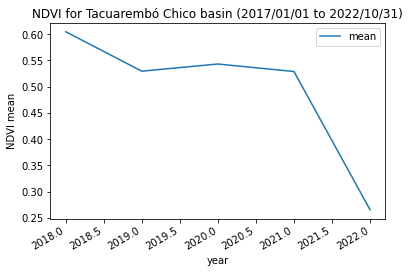

In [75]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates

ax = df2.plot()

plt.gcf().autofmt_xdate()
plt.xlabel("year")
plt.ylabel("NDVI mean")
plt.title('NDVI for Tacuarembó Chico basin (2017/01/01 to 2022/10/31)')

plt.show()